# Practical 3: Feature Selection & Dimension Reduction
#### Ayoub Bagheri
<img src="img/uu_logo.png" alt="logo" align="right" title="UU" width="50" height="20" />

#### Applied Text Mining - Utrecht Summer School

In this practical, we are going to learn about feature selection and dimension reduction methods for text data.

Today we will use the following libraries. Take care to have them installed!

In [1]:
from sklearn.datasets import load_files
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

### Let's get started!

1\. **Here we are going to use a news article data set, originating from BBC news website. This dataset was provided for benchmarking machine learning algorithms. The BBC data set consists of 2,225 documents and 5 categories: business, entertainment, politics, sport, and tech. Upload the `data.zip` file and extract it using the code below.**

In [2]:
# for reproducibility
random_state = 321
!unzip /content/data.zip # enter [N]


Archive:  /content/data.zip
   creating: bbc/
   creating: bbc/business/
  inflating: bbc/business/001.txt    
  inflating: bbc/business/002.txt    
  inflating: bbc/business/003.txt    
  inflating: bbc/business/004.txt    
  inflating: bbc/business/005.txt    
  inflating: bbc/business/006.txt    
  inflating: bbc/business/007.txt    
  inflating: bbc/business/008.txt    
  inflating: bbc/business/009.txt    
  inflating: bbc/business/010.txt    
  inflating: bbc/business/011.txt    
  inflating: bbc/business/012.txt    
  inflating: bbc/business/013.txt    
  inflating: bbc/business/014.txt    
  inflating: bbc/business/015.txt    
  inflating: bbc/business/016.txt    
  inflating: bbc/business/017.txt    
  inflating: bbc/business/018.txt    
  inflating: bbc/business/019.txt    
  inflating: bbc/business/020.txt    
  inflating: bbc/business/021.txt    
  inflating: bbc/business/022.txt    
  inflating: bbc/business/023.txt    
  inflating: bbc/business/024.txt    
  inflating: bb

 **Load the dataset and convert it to a dataframe.**

In [3]:
data = load_files('/content/bbc', encoding="utf-8", decode_error="replace", random_state=random_state)
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df.head()

,text,label
0,Chris Evans back on the market\n\nBroadcaster ...,1
1,Giggs handed Wales leading role\n\nRyan Giggs ...,3
2,Wales silent on Grand Slam talk\n\nRhys Willia...,3
3,Kenya lift Chepkemei's suspension\n\nKenya's a...,3
4,Lee to create new film superhero\n\nComic book...,1


2\. **Print the unique target names in your data and check the number of articles in each category. Then split your data into training (80%) and test (20%) sets.**

In [4]:
labels, counts = np.unique(df['label'], return_counts=True) # np.unique(data.target, return_counts=True)

In [5]:
print(dict(zip(data.target_names, counts)))

{'business': 510, 'entertainment': 386, 'politics': 417, 'sport': 511, 'tech': 401}


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=random_state)

3\. **Use the `CountVectorizer` from `sklearn` and convert the text data into a document-term matrix. What is the difference between `CountVectorizer` and `tfidfVectorizer(use_idf=False)`?**

In [7]:
#tokenizer to remove unwanted elements from out data like symbols
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
# If you have memory issues, reduce the max_features value so you can continue with the practical
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=token.tokenize,
                             stop_words='english',
                             ngram_range=(1, 2),
                             analyzer='word',
                             min_df=3,
                             max_features=None)

# fit_transform() does two functions: First, it fits the model and learns the vocabulary;
# second, it transforms our data into feature vectors.
# The input to fit_transform should be a list of strings.
bbc_dtm = vectorizer.fit_transform(X_train)
print(bbc_dtm.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1780, 25223)


The only difference is that the `TfidfVectorizer()` returns floats while the `CountVectorizer()` returns ints. And that’s to be expected – as explained in the documentation quoted above, `TfidfVectorizer()` assigns a score while `CountVectorizer()` counts.

4\. **Print top 20 most frequent words in the training set.**

In [8]:
importance = np.argsort(np.asarray(bbc_dtm.sum(axis=0)).ravel())[::-1]
feature_names = np.array(vectorizer.get_feature_names_out())
feature_names[importance[:20]]

array(['s', 'said', 'mr', 'year', 'people', 'new', 't', 'time', 'world',
       'government', 'uk', 'years', 'best', 'just', 'told', 'film',
       'make', '1', 'game', 'like'], dtype=object)

### Filter-based feature selection

5\. **From the feature selection library in `sklearn` load the `SelectKBest` function and apply it on the BBC dataset using the chi-squared method. Extract top 20 features.**

In [9]:
X_test_vectorized = vectorizer.transform(X_test)

In [10]:
ch2 = SelectKBest(chi2, k=20)
ch2.fit_transform(bbc_dtm, y_train)

<1780x20 sparse matrix of type '<class 'numpy.int64'>'
	with 4428 stored elements in Compressed Sparse Row format>

In [11]:
feature_names_chi = [feature_names[i] for i
                         in ch2.get_support(indices=True)]

In [12]:
feature_names_chi

['best',
 'blair',
 'brown',
 'computer',
 'digital',
 'election',
 'film',
 'government',
 'labour',
 'minister',
 'mobile',
 'mr',
 'mr blair',
 'music',
 'net',
 'party',
 'people',
 'software',
 'technology',
 'users']

6\. **Repeat the analysis in Question 5 with the mutual information feature selection method. Do you get the same list of words as compared to the chi-squared method?**

In [13]:
mutual_info = SelectKBest(mutual_info_classif, k=20)
mutual_info.fit_transform(bbc_dtm, y_train)

<1780x20 sparse matrix of type '<class 'numpy.int64'>'
	with 6350 stored elements in Compressed Sparse Row format>

In [14]:
feature_names_mutual_info = [feature_names[i] for i
                         in mutual_info.get_support(indices=True)]
feature_names_mutual_info

['blair',
 'coach',
 'election',
 'film',
 'firm',
 'game',
 'government',
 'labour',
 'market',
 'minister',
 'mr',
 'music',
 'party',
 'people',
 'said',
 'secretary',
 'technology',
 'tory',
 'users',
 'win']

Now you can build a classifier and train it using the output of these feature selection techniques. We are not going to do this right now, but if you are interested you can transform your training and test set using the selected features and continue with your classifier! Here are some tips:

In [15]:
# X_train = mutual_info.fit_transform(bbc_dtm, y_train)
# X_test = mutual_info.transform(X_test_vectorized)

### Embedded feature selection

7\. **One of the functions for embedded feature selection is the `SelectFromModel` function in `sklearn`. Use this function with L1 norm SVM and check how many non-zero coefficients left in the model.**

In [16]:
print("shape of the matrix before applying the embedded feature selection:", bbc_dtm.shape)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
model = SelectFromModel(lsvc).fit(bbc_dtm, y_train) # you can add threshold=0.18 as another argument to select features that have an importance of more than 0.18
X_new = model.transform(bbc_dtm)
print("shape of the matrix after applying the embedded feature selection:", X_new.shape)

shape of the matrix before applying the embedded feature selection: (1780, 25223)
shape of the matrix after applying the embedded feature selection: (1780, 154)


In [17]:
model

SelectFromModel(estimator=LinearSVC(C=0.01, dual=False, penalty='l1'))

In [18]:
# you can also check the coefficient values
model.estimator_.coef_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

8\. **What are the top features according to the SVM model? Tip: Use the function `model.get_support()` to find these features.**

In [19]:
model.get_support()

array([False, False, False, ..., False, False, False])

In [20]:
print("Features selected by SelectFromModel: ", feature_names[model.get_support()])

Features selected by SelectFromModel:  ['000' '1' '2' '2004' '6' 'airlines' 'album' 'analysts' 'apple' 'athens'
 'athletics' 'award' 'ballet' 'ban' 'band' 'bank' 'bbc' 'best' 'bid'
 'blair' 'blog' 'book' 'britain' 'broadband' 'brown' 'business' 'champion'
 'chart' 'chelsea' 'chief' 'children' 'china' 'club' 'coach' 'comedy'
 'companies' 'company' 'computer' 'conte' 'content' 'council' 'cup' 'data'
 'deal' 'digital' 'dollar' 'doping' 'drugs' 'e' 'economic' 'economy'
 'education' 'election' 'england' 'eu' 'european' 'euros' 'film'
 'financial' 'firm' 'firms' 'fraud' 'game' 'games' 'gaming' 'glazer'
 'good' 'government' 'group' 'growth' 'high' 'home' 'howard' 'iaaf'
 'information' 'injury' 'just' 'labour' 'league' 'like' 'liverpool' 'lord'
 'm' 'make' 'market' 'match' 'microsoft' 'million' 'minister' 'mobile'
 'mps' 'mr' 'music' 'musical' 'net' 'new' 'nintendo' 'number' 'o' 'oil'
 'old' 'olympic' 'online' 'party' 'people' 'plans' 'play' 'players'
 'police' 'president' 'prices' 'public' 'r

### Model comparison

9\. **Create a pipeline with the tfidf representation and a random forest classifier.**

In [21]:
clf1 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('classification', RandomForestClassifier())
])

10\. **Fit the pipeline on the training set.**

In [22]:
clf1.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('classification', RandomForestClassifier())])

11\. **Use the pipeline to predict the outcome variable on your test set. Evaluate the performance of the pipeline using the `classification_report` function on the test subset. How do you interpret your results?**

In [23]:
y_pred1 = clf1.predict(X_test)
print(metrics.classification_report(y_test, y_pred1, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.95      0.96      0.95        92
entertainment       0.98      0.94      0.96        84
     politics       0.93      0.92      0.93        77
        sport       0.97      0.99      0.98       111
         tech       0.96      0.98      0.97        81

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



12\. **Create your second pipeline with the tfidf representation and a random forest classifier with the addition of an embedded feature selection using the SVM classification method with L1 penalty. Fit the pipeline on your training set and test it with the test set. How does the performance change?**

In [24]:
clf2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', RandomForestClassifier())
])

In [25]:
clf2.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', RandomForestClassifier())])

In [26]:
y_pred2 = clf2.predict(X_test)

In [27]:
print(metrics.classification_report(y_test, y_pred2, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.91      0.93      0.92        92
entertainment       0.96      0.93      0.95        84
     politics       0.91      0.91      0.91        77
        sport       1.00      0.99      1.00       111
         tech       0.94      0.96      0.95        81

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



13\. **Create your third and forth pipelines with the tfidf representation, a chi2 feature selection (with 20 and 200 features for `clf3` and `clf4`, respectively), and a random forest classifier.**

In [28]:
clf3 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectKBest(chi2, k=20)),
    ('classification', RandomForestClassifier())
])

In [29]:
clf3.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectKBest(k=20,
                             score_func=<function chi2 at 0x7fd8444d23b0>)),
                ('classification', RandomForestClassifier())])

In [30]:
y_pred3 = clf3.predict(X_test)
print(metrics.classification_report(y_test, y_pred3, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.65      0.46      0.54        92
entertainment       0.80      0.57      0.67        84
     politics       0.79      0.73      0.76        77
        sport       0.63      0.98      0.76       111
         tech       0.88      0.81      0.85        81

     accuracy                           0.72       445
    macro avg       0.75      0.71      0.71       445
 weighted avg       0.74      0.72      0.71       445



In [31]:
clf4 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectKBest(chi2, k=200)),
    ('classification', RandomForestClassifier())
])

In [32]:
clf4.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectKBest(k=200,
                             score_func=<function chi2 at 0x7fd8444d23b0>)),
                ('classification', RandomForestClassifier())])

In [33]:
y_pred4 = clf4.predict(X_test)
print(metrics.classification_report(y_test, y_pred4, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.86      0.92      0.89        92
entertainment       0.97      0.90      0.94        84
     politics       0.92      0.88      0.90        77
        sport       0.99      0.98      0.99       111
         tech       0.93      0.96      0.95        81

     accuracy                           0.93       445
    macro avg       0.93      0.93      0.93       445
 weighted avg       0.94      0.93      0.94       445



14\. **We can change the learner by simply plugging a different classifier object into our pipeline. Create your fifth pipeline with L1 norm SVM for the feature selection method and naive Bayes for the classifier. Compare your results on the test set with the previous pipelines.**

In [34]:
clf5 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', MultinomialNB(alpha=0.01))
])

In [35]:
clf5.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', MultinomialNB(alpha=0.01))])

In [36]:
y_pred5 = clf5.predict(X_test)
print(metrics.classification_report(y_test, y_pred5, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.96      0.93      0.95        92
entertainment       1.00      0.94      0.97        84
     politics       0.95      0.99      0.97        77
        sport       1.00      1.00      1.00       111
         tech       0.93      0.98      0.95        81

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



### Optional: Dimension reduction

15\. **Dimensionality reduction methods such as PCA and SVD can be used to project the data into a lower dimensional space. If you run PCA with your text data, you might end up with the message:**

<blockquote> PCA does not support sparse input. See TruncatedSVD for a possible alternative. </blockquote>

**Therefore, we will use the `TruncatedSVD` function from the `sklearn` package and we want to find out how much of the variance in the BBC data set is explained with different components. For this, first create a tfidf matrix and use that to make a co-occurrence matrix.**

In [37]:
tfidf_vect = TfidfVectorizer()
X = tfidf_vect.fit_transform(X_train)
Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
print("Shape of the TFIDF vectorizer:", X.shape)

Shape of the TFIDF vectorizer: (1780, 26739)


In [38]:
print(Xc.todense()) # print out matrix in dense format

[[0.         0.00024418 0.         ... 0.         0.         0.        ]
 [0.00024418 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


16\. **Run the `TruncatedSVD` function with different values for components: 1, 2, 4, 5, 10, 15, 20, 50, 100. Plot the explained variance ratio for each component of Truncated SVD.**

Number of components = 1 and explained variance = 0.8302335701200982
Number of components = 2 and explained variance = 0.916509363220827
Number of components = 4 and explained variance = 0.9291569440571863
Number of components = 5 and explained variance = 0.934486055353985
Number of components = 10 and explained variance = 0.9477460365510288
Number of components = 15 and explained variance = 0.9529731073724189
Number of components = 20 and explained variance = 0.9560375991471989
Number of components = 50 and explained variance = 0.9645814066707994
Number of components = 100 and explained variance = 0.971119162449249


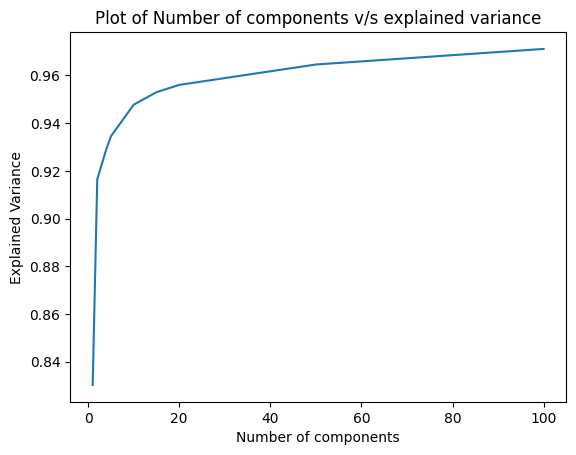

In [39]:
n_comp = [1, 2, 4, 5, 10, 15, 20, 50, 100] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x, random_state=321)
    svd.fit(Xc)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

17\. **How many components are needed to explain at least 95% of the variance?**

Based on the selected values, it seems 15 components are needed to explain 95% of the variance.

18\. **Use these components and train a SVM model on the BBC dataset. Make a pipeline for your model. Compare your results on the test set with the previous pipelines.**

In [40]:
clf6 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', TruncatedSVD(n_components=15, random_state=321)),
    ('classification', LinearSVC())
])

In [41]:
clf6.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 TruncatedSVD(n_components=15, random_state=321)),
                ('classification', LinearSVC())])

In [42]:
y_pred6 = clf6.predict(X_test)
print(metrics.classification_report(y_test, y_pred6, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.91      0.92      0.92        92
entertainment       1.00      0.94      0.97        84
     politics       0.91      0.92      0.92        77
        sport       0.99      1.00      1.00       111
         tech       0.94      0.96      0.95        81

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445

